# **PA5: Cybersecurity Attack Classification Using Random Forest**



In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dfset
df = pd.read_csv('cyber_attacks(in).csv')

# Display first few rows and basic info
print(df.head())
print(df.info())

   protocol_type   duration    src_bytes   dst_bytes  num_packets  \
0              1  43.418651  1701.411601  201.794741           42   
1              1   8.587924   409.971403  710.745376           17   
2              1   4.386891   418.478693  559.457816           17   
3              0        NaN          NaN         NaN           11   
4              0   1.061892   494.253699  572.459614           11   

   num_connections attack_type  
0               15      Botnet  
1                6      Normal  
2                5      Normal  
3                3      Normal  
4                3      Normal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   protocol_type    10000 non-null  int64  
 1   duration         9500 non-null   float64
 2   src_bytes        9500 non-null   float64
 3   dst_bytes        9500 non-null   float64
 4  

## Exploratory Data Analysis

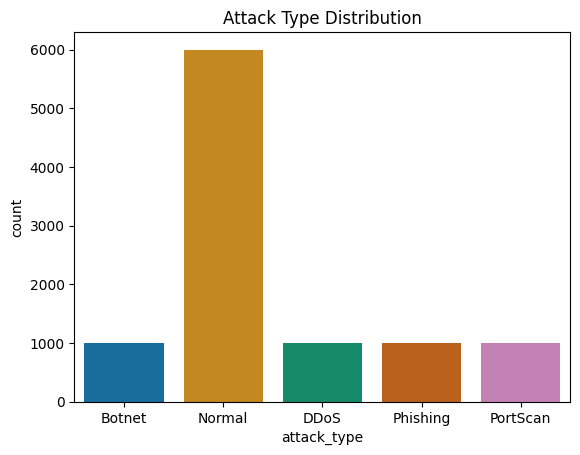

In [11]:
# Visualize class distribution
sns.countplot(x='attack_type', data=df, hue='attack_type' ,palette='colorblind', legend=False)
plt.title('Attack Type Distribution')
plt.show()

## Data Preprocessing

In [12]:
# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Encode categorical features
le = LabelEncoder()
df['protocol_type'] = le.fit_transform(df['protocol_type'])
df['attack_type'] = le.fit_transform(df['attack_type'])

# Address class imbalance by Upsampling
majority_class = df[df['attack_type'] == df['attack_type'].mode()[0]]
minority_classes = df[df['attack_type'] != df['attack_type'].mode()[0]]
minority_upsampled = resample(minority_classes, replace=True, n_samples=len(majority_class), random_state=42)
data_balanced = pd.concat([majority_class, minority_upsampled])

# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


## Split and Train Dataset


In [23]:
# Split dataset
X = data_balanced.drop('attack_type', axis=1)
y = data_balanced['attack_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

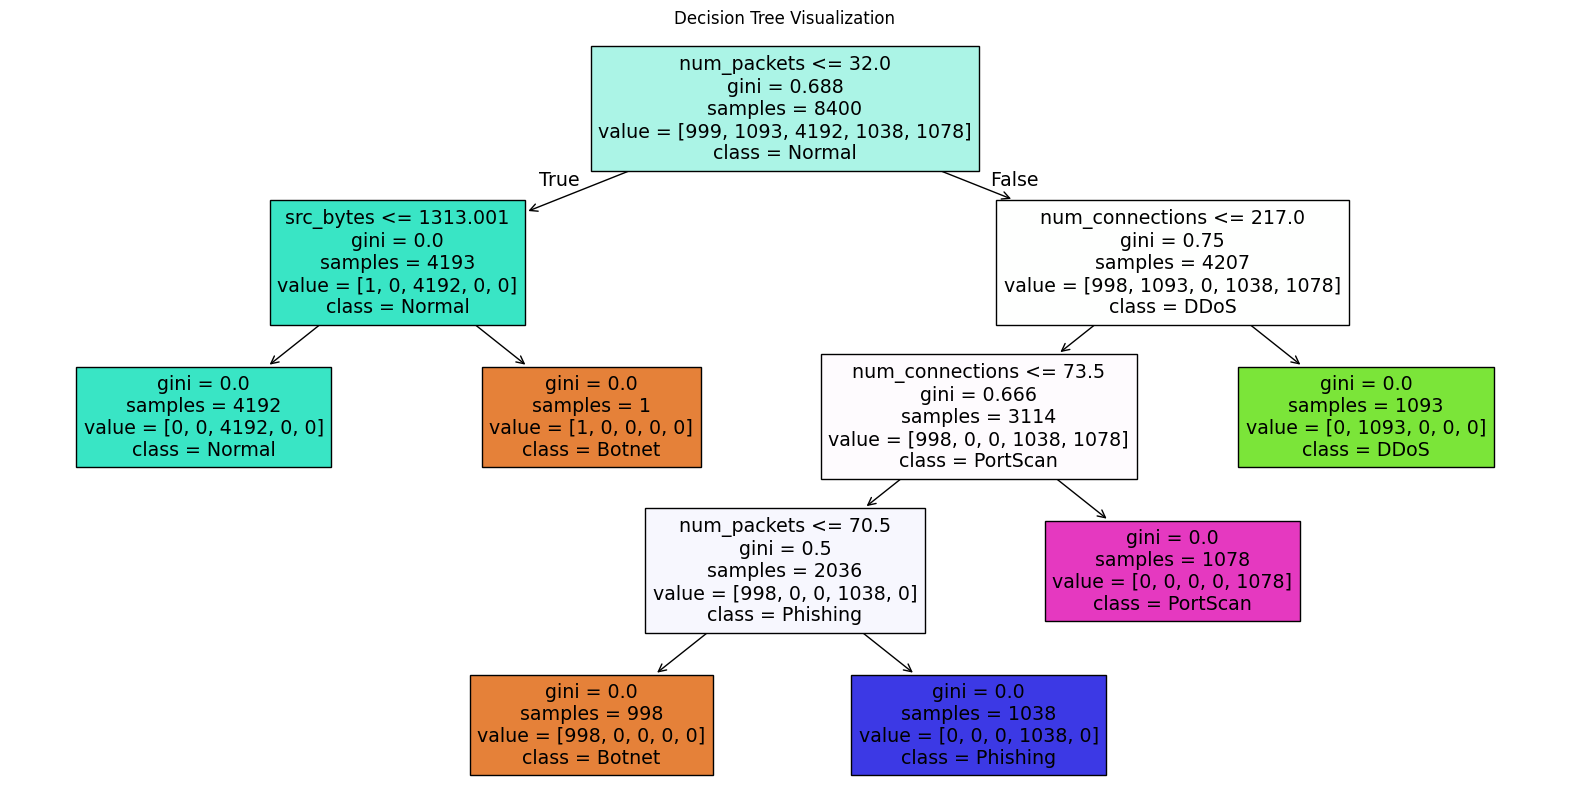

In [24]:
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=22)
dt_clf.fit(X_train, y_train)

class_mapping = {i: le.classes_[i] for i in range(len(le.classes_))}

plt.figure(figsize=(20, 10))
plot_tree(dt_clf, feature_names=X.columns, class_names=[class_mapping[i] for i in np.unique(y_train)], filled=True)
plt.title('Decision Tree Visualization')
plt.show()


# Hyperparameter Tuning

In [25]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=22, class_weight='balanced'))
])

In [26]:
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_macro',
    'recall': 'recall_macro',
    'f1': 'f1_macro'
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=22))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 20],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1_macro',
                      'precision': 'precision_macro',
                      'recall': 'recall_macro'},
             verbose=1)


 Grid Search Results 
Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best Cross-Validation Accuracy Score: 1.0000
F1 Score: 1.0000


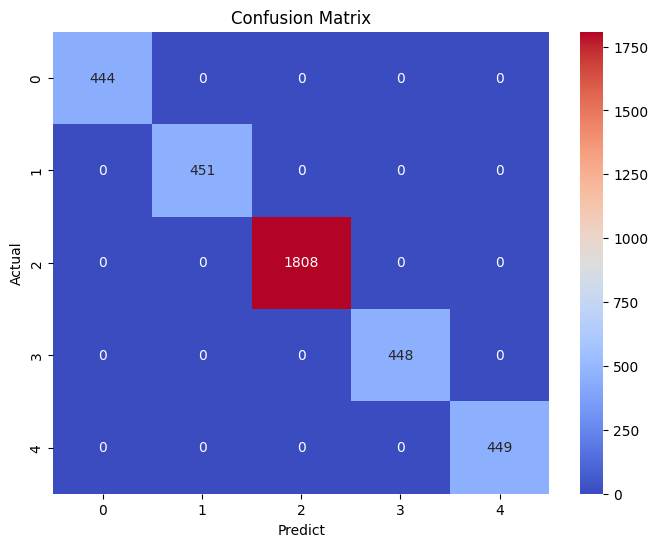

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       451
           2       1.00      1.00      1.00      1808
           3       1.00      1.00      1.00       448
           4       1.00      1.00      1.00       449

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600


 Test Results 
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000


In [36]:
# Best parameters and results
print("\n Grid Search Results ")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy Score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate best model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='d', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predict')
print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.4f}")
plt.ylabel('Actual')
plt.show()
print("Classification Report:")
print(classification_report(y_test, y_pred))
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\n Test Results ")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.4f}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.4f}")


In [19]:
# Feature importance
rf_clf = best_model.named_steps['classifier']
importances = rf_clf.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


In [30]:
# Classification Report to Identify Hard-to-Classify Attack Types
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       444
           1       1.00      1.00      1.00       451
           2       1.00      1.00      1.00      1808
           3       1.00      1.00      1.00       448
           4       1.00      1.00      1.00       449

    accuracy                           1.00      3600
   macro avg       1.00      1.00      1.00      3600
weighted avg       1.00      1.00      1.00      3600



C:\Users\jhr\AppData\Local\Temp\ipykernel_4652\3490070762.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='colorblind')


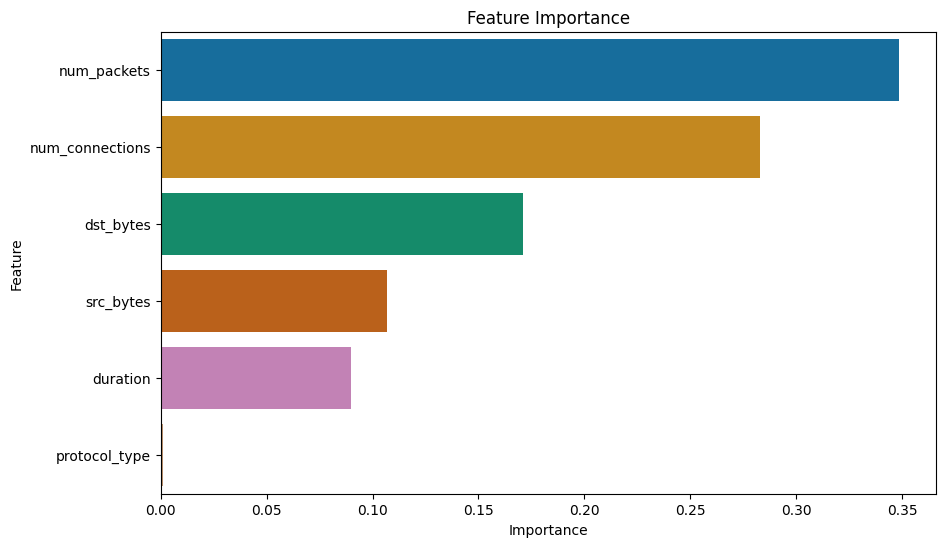

In [20]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='colorblind')
plt.title('Feature Importance')
plt.show()

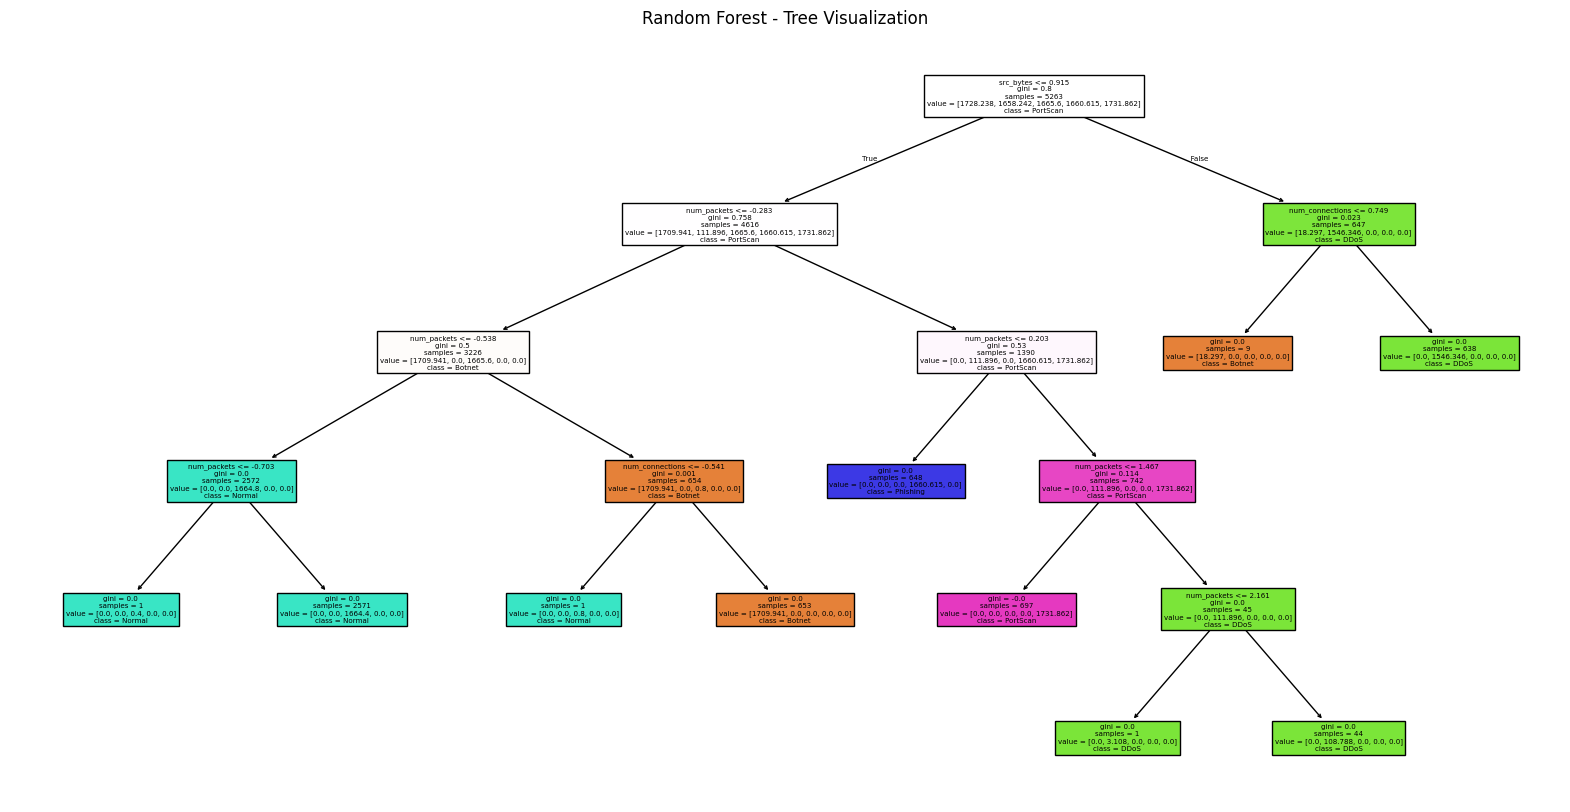

In [27]:
# Visualize one of the trees from the Random Forest
plt.figure(figsize=(20, 10))
from sklearn import tree
tree.plot_tree(rf_clf.estimators_[0], feature_names=X.columns, class_names=[class_mapping[i] for i in np.unique(y_train)], filled=True)
plt.title('Random Forest - Tree Visualization')
plt.show()

# Guide Questions

## 1. Preprocessing

### How did you handle missing values in numerical features?
- We filled the missing values with the median for each column ` data.fillna(data.median(numeric_only=True), inplace=True) `. The median is better to use for outliers, making it ideal for handling numerical features in datasets where extreme values could skew the results.

### Why is there a need to encode the protocol_type feature, and which encoding method can be used?
- The `protocol_type` feature is categorical (e.g., TCP, UDP, ICMP), and machine learning models can’t work with non-numeric data directly. We used Label Encoding to convert each protocol type into an integer.

## 2. Model Training

### How did you address class imbalance in the dataset?
- We used upsampling to balance the classes. This involves replicating samples from the minority classes until they match the size of the majority class. It prevents the model from being biased toward more frequent attack types.

### What hyperparameters of the Random Forest did you tune, and why?
- **Tuned Parameters:**
  - `n_estimators`: Number of trees in the forest. Higher values improve model performance but increase training time.
  - `max_depth`: Controls the depth of each tree to prevent overfitting.
  - `min_samples_split`: Minimum number of samples required to split a node, helping with generalization.
  - `min_samples_leaf`: Minimum samples required at each leaf node. Helps prevent leaves from having too few samples, improving generalization.

### Why is a pipeline useful for this task?
- Pipeline simplifies the workflow by ensuring that preprocessing (like scaling) and model training are applied consistently. It reduces code redundancy and minimizes the risk of data leakage by ensuring that transformations are only applied to the training set during cross-validation.

## 3. Evaluation

### Why is accuracy alone insufficient to evaluate this model?
- In imbalanced datasets, accuracy can be misleading. For example, if 90% of traffic is normal and the model predicts "Normal" every time, accuracy will be high, but the model would completely fail at detecting attacks. Using precision, recall, and F1-score gives a better picture of performance across classes.

### Which attack type was hardest to classify, and why might this be?
- Identifying the hardest attack type is not certain. Some attacks might resemble normal traffic or each other, making them harder to distinguish.

### How would you improve the model’s performance on minority classes?
- Experiment with Synthetic Minority Oversampling Technique (SMOTE) instead of simple upsampling.
- Implement additional resampling methods like **oversampling** or **undersampling**.
- Use class weights in **RandomForestClassifier** to penalize wrong predictions on minority classes.
- Try feature engineering to create new features that may make attack types more distinguishable.

## 4. Interpretation

### Which features were most important for classification? Does this align with real-world attack patterns?
- The code plots feature importance. In cybersecurity, features like "src_bytes", "dst_bytes", or "duration" may align with real-world attack patterns, where sudden spikes in traffic or unusual packet sizes can indicate attacks.

### How would you explain the model’s decision-making process to a non-technical team?
- Visualize a decision tree to demonstrate how the model makes split decisions, using simple if-else conditions like "If src_bytes > 1000, then it's likely an attack."
- Use the feature importance plot to show which factors contribute most to detecting attacks.

## 5. Application

### What steps would you take to deploy this model in a real-time network monitoring system?
- Model Export: Save the trained model with joblib or pickle.
- Integration: Wrap the model into a web API using Flask or FastAPI, allowing it to receive traffic data and return predictions.
- Real-Time Processing: Use message queues (e.g., Kafka) to handle continuous streams of data.
- Monitoring: Track model performance and retrain periodically with new data.

### How would you handle new attack types not present in the training data?
- Implement an anomaly detection system alongside the classifier to flag unfamiliar patterns.
- Periodically retrain the model with updated datasets that contain new attack types.
- Use unsupervised learning methods like clustering to detect outliers that could represent new attacks.